In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9# enter the number of inside corners in x
ny = 6# enter the number of inside corners in y

objp  = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [ ]:
objp.shape

In [ ]:
import matplotlib.pyplot as plt
import glob
import cv2
import pickle


objpoints =[]
imgpoints =[]
print ( " .. starting  ")

plt.axis('off')
i = 0
for fname in glob.glob("./camera_cal/*"):
#     print (name)\
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners )


    i += 1
    plt.axis('off')
#     plt.imshow(img)
#     plt.show()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )    
print ( " .. completed .. saved into wide_dist_pickle.p  ")

## Creating test images from the videos

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class save_images ( object ):
    def __init__( self ):
        self.i = 0
    def __call__( self, image):
        # do something
        self.i +=1
        cv2.imwrite("test_images2/image" + str(self.i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        return image
    
save_images = save_images()    
    
## creating additional test images
from moviepy.editor import VideoFileClip
output_video_name = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
clip2 = clip1.subclip(0,2)
output_video = clip2.fl_image(save_images) #NOTE: this function expects color images!!

%time output_video.write_videofile(output_video_name, audio=False)






In [ ]:
class save_images ( object ):
    def __init__( self ):
        self.i = 0
    def __call__( self, image):
        # do something
        self.i +=1
        cv2.imwrite("test_images3/image" + str(self.i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        return image
    
save_images = save_images()    
    
## creating additional test images
from moviepy.editor import VideoFileClip
output_video_name = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_video = clip1.fl_image(save_images) #NOTE: this function expects color images!!

%time output_video.write_videofile(output_video_name, audio=False)



## Working on test image
### Reading test image and undistorting it

In [225]:
import cv2

test_image = cv2.imread("test_images3/image594.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

In [226]:
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import numpy as np
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
print ( " mtx.shape = " + str(mtx.shape) )

undst = cv2.undistort(test_image, mtx, dist, None, mtx)
undst = np.copy(test_image)

 mtx.shape = (3, 3)


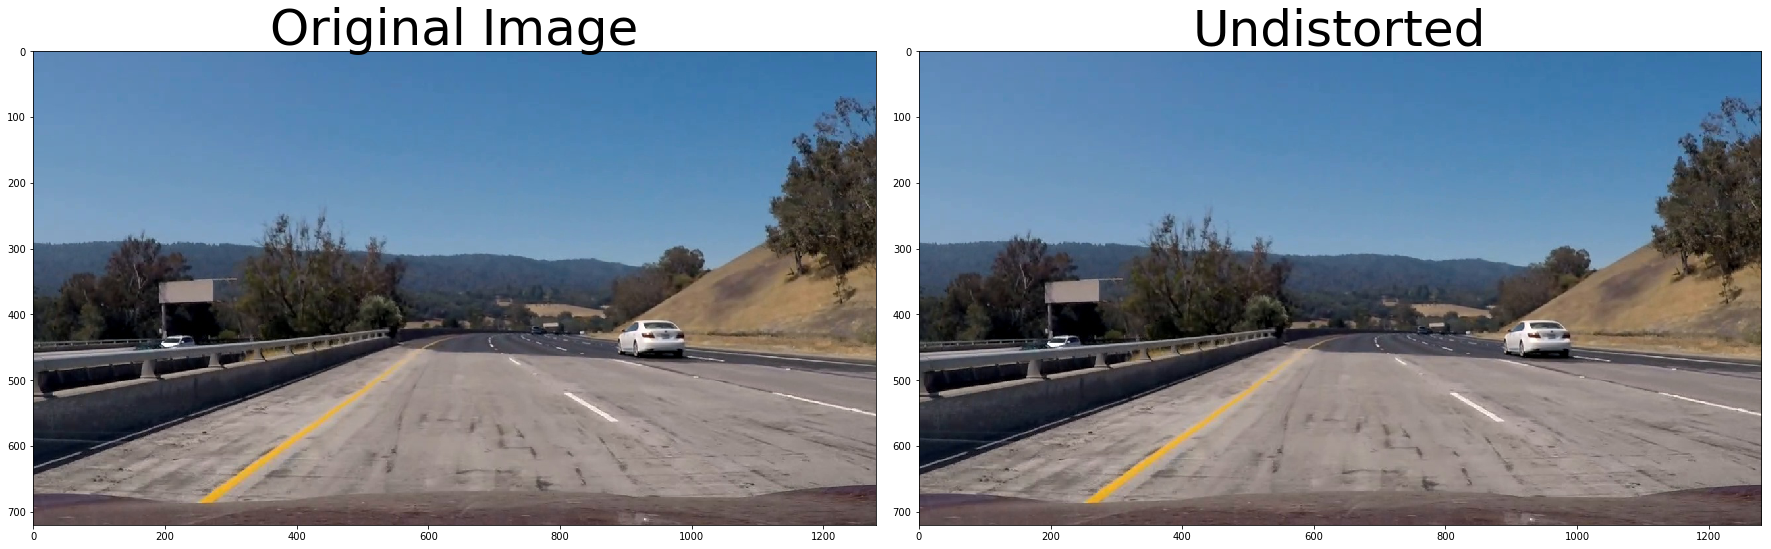

In [227]:
# top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(undst)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### experimenting thresholds
#### Sobel X on the gray image

In [228]:
gray = cv2.cvtColor(undst, cv2.COLOR_RGB2GRAY)

In [229]:
def sobelx(gray, thresh=(0.45, 2)):
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min =  np.mean(gray) * thresh[0]
    thresh_max = np.mean(gray)  * thresh[1]

    sobelx_binary = np.zeros_like(scaled_sobel)
    sobelx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sobelx_binary


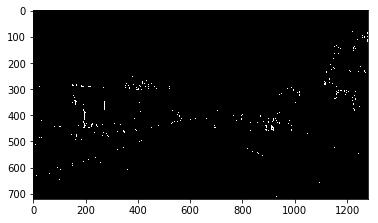

In [230]:
sobelx_binary  = sobelx(gray)
temp = np.dstack(( sobelx_binary, sobelx_binary, sobelx_binary)) *255

plt.imshow(temp)
plt.show()

### Magnitude

In [231]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
import numpy as np

def mag_thresh(input_gray_img, sobel_kernel=3, thresh=(0.45, 2)):

    # Threshold x gradient
    thresh_min =  np.mean(input_gray_img) * thresh[0]
    thresh_max = np.mean(input_gray_img)  * thresh[1]

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(input_gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(input_gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output

112.307642144


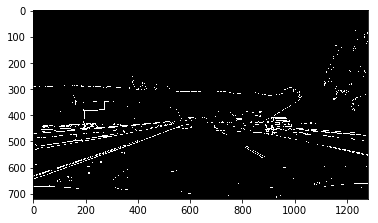

In [232]:
# Convert to grayscale
gray = cv2.cvtColor(undst, cv2.COLOR_RGB2GRAY)
print (np.mean(gray))
mag_binary = mag_thresh(gray, sobel_kernel=3)
plt.imshow(np.dstack((mag_binary,mag_binary,mag_binary))*255)
plt.show()

### gradient direction

In [233]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(input_gray_img, sobel_kernel=5, thresh=(.6,1.3)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(input_gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(input_gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

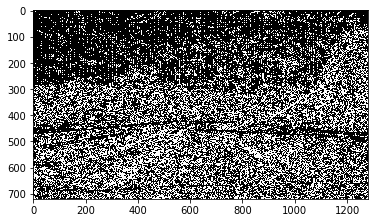

In [234]:
# Grayscale
gray = cv2.cvtColor(undst, cv2.COLOR_RGB2GRAY)

dir_binary = dir_threshold(gray)
temp = np.dstack((dir_binary,dir_binary,dir_binary)) #*255
plt.imshow(temp)
plt.show()

### Choosing the best HLS channel

In [235]:
# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(undst, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
h_channel_color = np.dstack((h_channel, h_channel, h_channel)) #*255
l_channel_color = np.dstack((l_channel, l_channel, l_channel)) #*255
s_channel_color = np.dstack((s_channel, s_channel, s_channel)) #*255

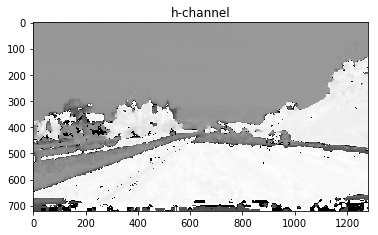

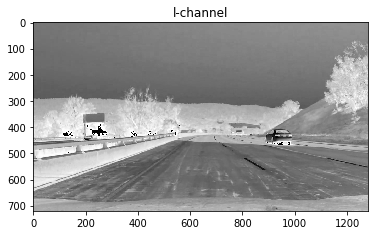

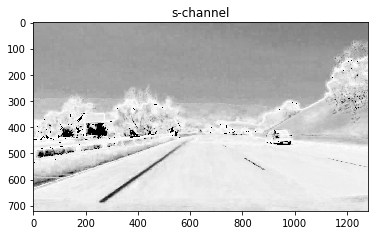

In [236]:
plt.imshow(h_channel_color, cmap="gray")
plt.title ("h-channel")
plt.show()

plt.imshow(l_channel_color, cmap="gray")
plt.title ("l-channel")
plt.show()

plt.imshow(s_channel_color, cmap="gray")
plt.title ("s-channel")
plt.show()



### S-channel Threshold

In [237]:
def hls_select(img, thresh,channel):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == "s":
        channel = hls[:,:,2]
    elif channel =="h":        
        channel = hls[:,:,0]
    elif channel =="l":        
        channel = hls[:,:,1]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]*np.mean(channel)) & (channel <= thresh[1]*np.mean(channel))] = 1
    return binary_output

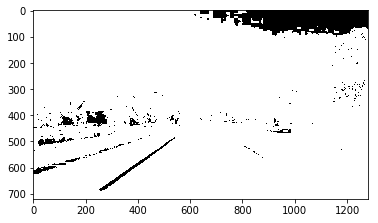

In [238]:
s_binary = hls_select(undst,thresh=(0, 1.9),channel="s")
temp = np.dstack((s_binary,s_binary,s_binary)) *255
plt.imshow(temp,cmap="gray")
plt.show()

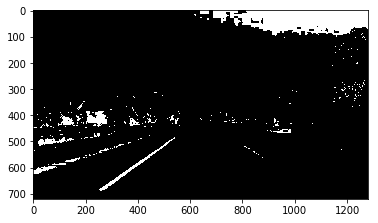

60606


In [246]:
## the s-channel works well identifying in black the white lines
s_binary_temp = np.copy(s_binary)
## so I will invert the selection
s_binary_new = np.zeros_like(s_binary)
s_binary_new[s_binary_temp == 0 ] =1

temp = np.dstack((s_binary_new,s_binary_new,s_binary_new)) *255
plt.imshow(temp,cmap="gray")
plt.show()
print ( np.count_nonzero(s_binary_new))
##--16254


### l-channel Threshold


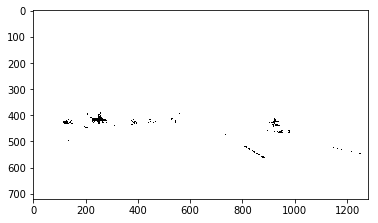

In [247]:
l_binary = hls_select(undst,thresh=(0, 2),channel="l")

plt.imshow(l_binary,cmap="gray")
plt.show()



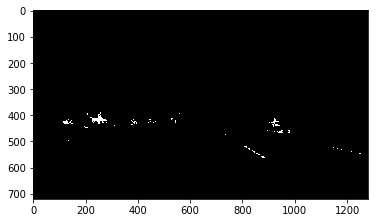

In [248]:
## the l-channel works well identifying in black the lines
l_binary_temp = np.copy(l_binary)
## so I will invert the selection
l_binary_new = np.zeros_like(l_binary)
l_binary_new[l_binary_temp == 0 ] =1

temp = np.dstack((l_binary_new,l_binary_new,l_binary_new)) *255
plt.imshow(temp,cmap="gray")
plt.show()



#### combining together s-channel/l-channel 

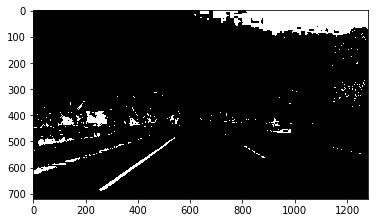

In [249]:
## in case of too many white points I will discard the image
if ( np.count_nonzero (s_binary_new) > 100000):
    s_binary_new = np.zeros_like(s_binary)


hls_combined = np.zeros_like(s_binary)
hls_combined[((s_binary_new == 1 )|(l_binary_new == 1 ))] = 1


plt.imshow(hls_combined, cmap="gray")

plt.show()

#### combining hls_combined and soebel x / dir binary / mag binary

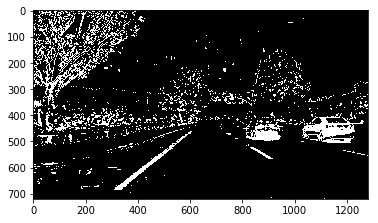

In [213]:
# Merge the images. Based on lots of trial and error
combined = np.zeros_like(dir_binary)
combined[(hls_combined == 1 )|((dir_binary == 1)&(mag_binary == 1)) |((sobelx_binary == 1)&(mag_binary == 1))] = 1

plt.imshow(combined, cmap="gray")
plt.show()

### Changing the perspective

In [214]:
def draw_poly (img, src_corners):
    img_draw = np.copy(img)
#     print ( src_corners[0][0])
#     print (src_corners[0][1])
    cv2.line(img_draw,tuple(src_corners[0]),
                      tuple(src_corners[3]),
                       (255,0,0),5)

    cv2.line(img_draw,tuple(src_corners[1]),
                      tuple(src_corners[2]),
                       (255,0,0),5)

    return img_draw



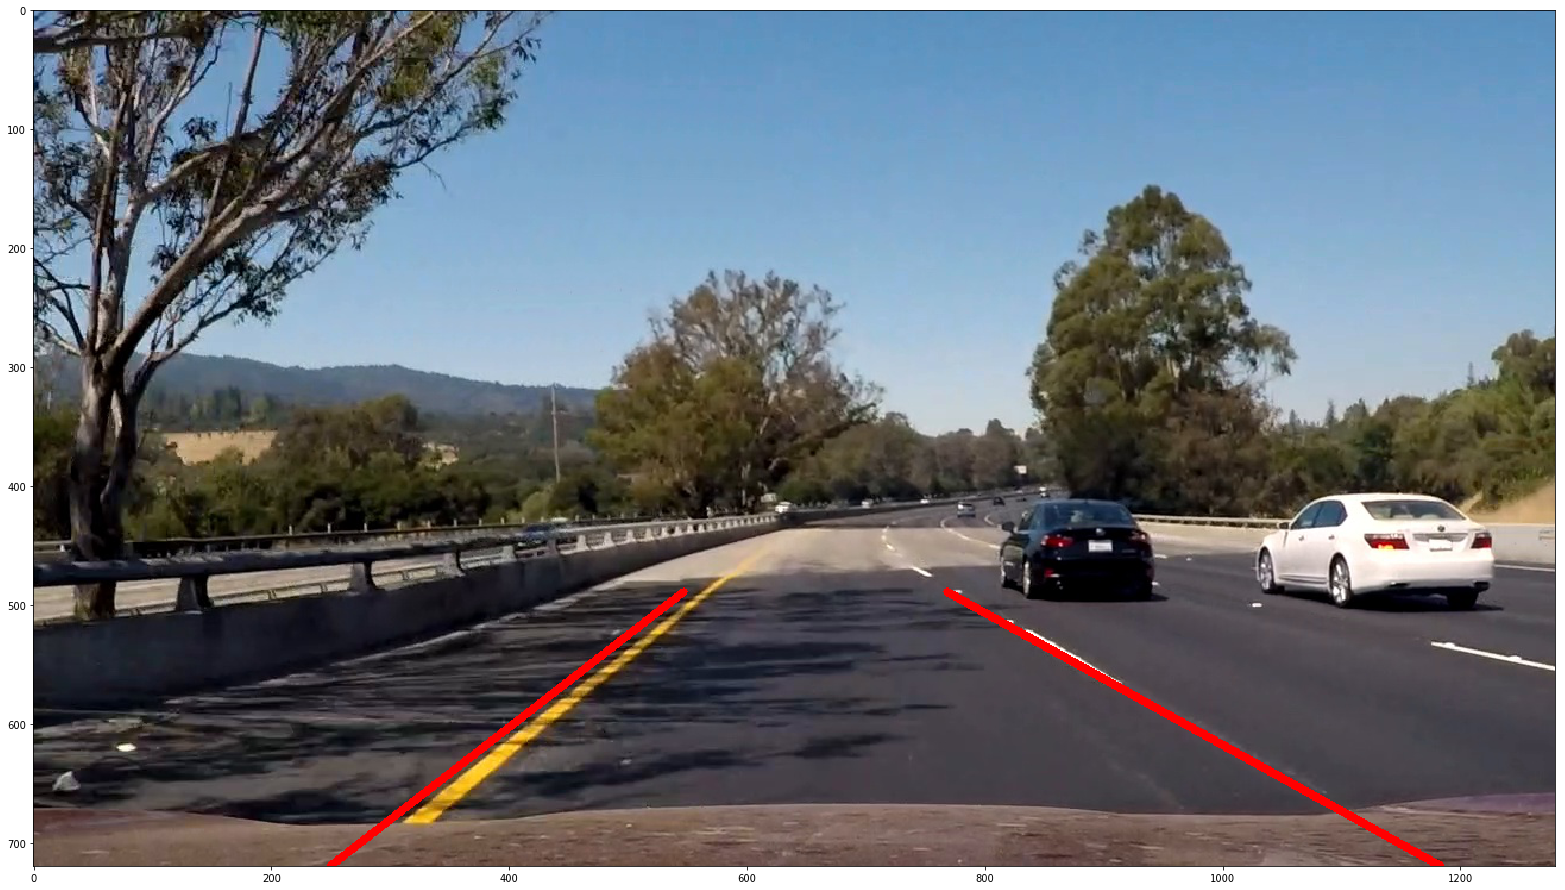

In [215]:

#######    
## calculate the source points for image warp ( bird eyes view )
#######    
def calc_src_corners(image):
    x_len = image.shape[1]
    y_len = image.shape[0]
    src_top_left     = [int(0.428*x_len),int(0.68*y_len)]
    src_top_right    = [int(0.60*x_len),int(0.68*y_len)]

    src_bottom_left  = [int(0.195*x_len),y_len]
    src_bottom_right = [int(0.925*x_len),y_len]

    src_corners = np.float32([src_top_left,
                          src_top_right,
                          src_bottom_right,
                          src_bottom_left])
    return src_corners

src_corners =    calc_src_corners(undst) 
drawed_poly = draw_poly(np.copy(undst), src_corners)

fig1 = plt.figure(figsize = (60,60)) # create a figure with the default size 
ax1 = fig1.add_subplot(2,2,1) 
ax1.imshow(drawed_poly, interpolation='none')
plt.show()

In [216]:
def bird_eyes (input_image , src_corners, dst_corners) :
    
    M = cv2.getPerspectiveTransform(src_corners, dst_corners)
    Minv = cv2.getPerspectiveTransform(dst_corners, src_corners)
    warped = cv2.warpPerspective(input_image, M, ( input_image.shape[1], input_image.shape[0]), flags=cv2.INTER_LINEAR)

    return warped, M, Minv


In [217]:
#######    
## calculate the destination points for image warp ( bird eyes view )
#######  
def calc_dst_corners(image):
    x_len = image.shape[1]
    y_len = image.shape[0]

    dst_bottom_left = [int(.335*x_len),y_len] 
    dst_bottom_right = [int(0.72*x_len), y_len]

    dst_top_left = [int(.335*x_len), 1]
    dst_top_right = [int(0.728*x_len), 1]

    dst_corners = np.float32([dst_top_left,
                              dst_top_right,
                              dst_bottom_right, 
                              dst_bottom_left
                             ])
    return dst_corners



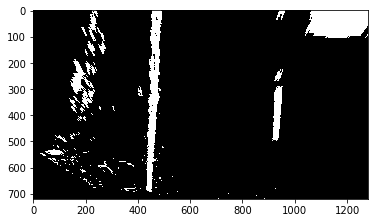

In [218]:
dst_corners = calc_dst_corners(combined)

warped , M, Minv = bird_eyes(combined,src_corners, dst_corners)
warped[warped > 0 ] = 1
plt.imshow(warped,cmap="gray")
plt.show()



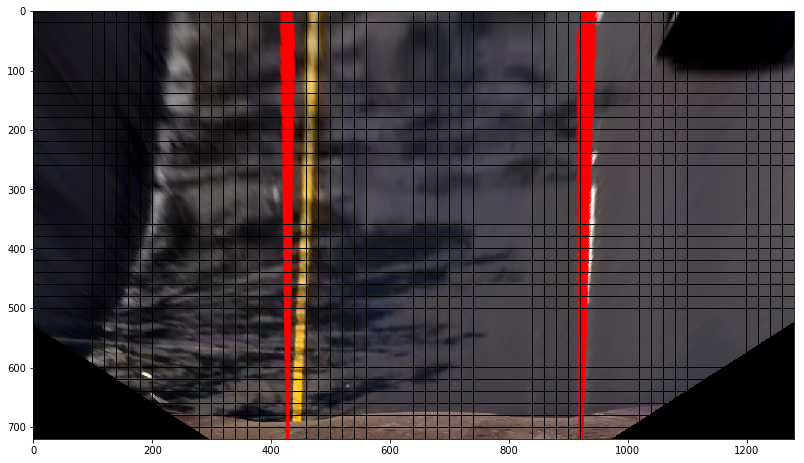

In [219]:
warped_drawed , M_drawed, Minv_drawed = bird_eyes(drawed_poly,src_corners, dst_corners)

temp = np.copy(warped_drawed)
fig1 = plt.figure(figsize = (30,30)) # create a figure with the default size 

# Grid lines at these intervals (in pixels)
# dx and dy can be different
dx, dy = 20,20

# Custom (rgb) grid color
grid_color = [0,0,0]

# Modify the image to include the grid
temp[:,::dy,:] = grid_color
temp[::dx,:,:] = grid_color

ax1 = fig1.add_subplot(2,2,1) 
ax1.imshow(temp, interpolation='none')
plt.show()


In [220]:
def remove_edge_pixels(img, side_thresh=200, bottom_tresh= 20):
    shape=img.shape
    w=shape[1]
    h=shape[0]
#     print ( "w=" + str(w))
#     print ( "h=" + str(h))

    # left
    cv2.rectangle(img,(0,0),(side_thresh,h),(0,0,0),side_thresh)
    #right
    cv2.rectangle(img,(w-side_thresh,0),(w,h),(0,0,0),side_thresh)

    #bottom
    cv2.rectangle(img,(0,h-bottom_tresh),(w,h-bottom_tresh),(0,0,0),bottom_tresh*2  )
    
    return img

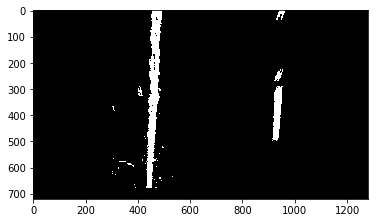

In [221]:
warped_cutted = remove_edge_pixels(warped)
plt.imshow(warped_cutted,cmap="gray")
plt.show()

### defining Pipeline function

In [250]:
# Edit this function to create your own pipeline.
def pipeline(input_img):

    # Convert to grayscale
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)

    # Threshold Soebelx
    sobelx_binary  = sobelx(gray)

    # Threshold magnitude
    mag_binary = mag_thresh(gray)

    ####
    # Direction threshold
    ####
    dir_binary = dir_threshold(gray)

    ####################################################
    # hls threshold
    ####################################################

    ####
    # s-binary
    ####

    s_binary = hls_select(input_img,thresh=(0, 1.9),channel="s")
    ## the s-channel works well identifying in black the white lines
    s_binary_temp = np.copy(s_binary)
    ## so I will invert the selection
    s_binary_new = np.zeros_like(s_binary)
    s_binary_new[s_binary_temp == 0 ] =1
    ### discarding the image in case of too many white points
    if ( np.count_nonzero (s_binary_new) > 100000):
        s_binary_new = np.zeros_like(s_binary)
    
    ####
    # l-binary
    ####
    l_binary = hls_select(input_img,thresh=(0, 2),channel="l")

    ## the l-channel works well identifying in black the lines
    l_binary_temp = np.copy(l_binary)
    ## so I will invert the selection
    l_binary_new = np.zeros_like(l_binary)
    l_binary_new[l_binary_temp == 0 ] =1

    ############################################
    #### combining together s-channel/l-channel 
    #######################################
    hls_combined = np.zeros_like(s_binary_new)
    hls_combined[((s_binary_new == 1 )|(l_binary_new == 1 ))] = 1

    ############################################
    #### combining hls_combined and soebel x / dir binary / mag binary
    #######################################
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[ (hls_combined == 1 )|\
                    ((dir_binary == 1)&(mag_binary == 1)) |\
                    ((sobelx_binary == 1)&(mag_binary == 1))] \
                   = 1


    
    return combined_binary.astype(np.uint8),  mag_binary , dir_binary, s_binary



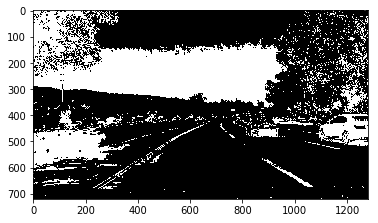

In [176]:
pipelined , mag_binary , dir_binary, s_binary = pipeline(undst)
plt.imshow(pipelined,cmap="gray")
plt.show()



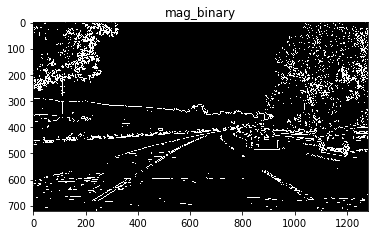

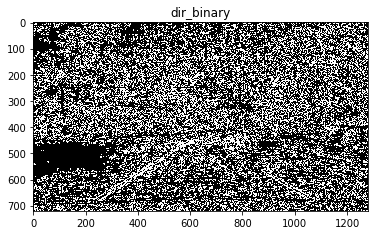

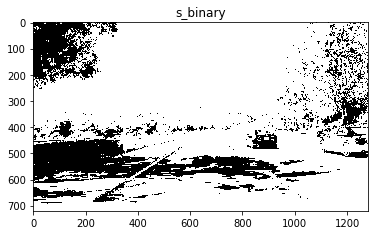

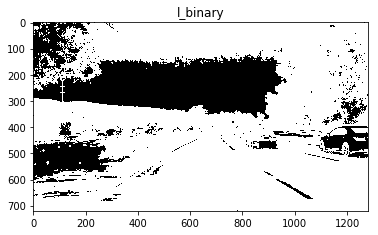

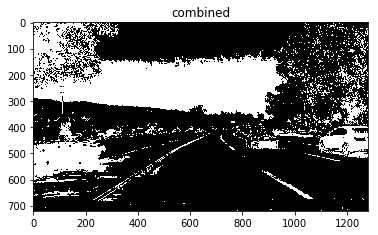

In [177]:
pipelined , mag_binary , dir_binary, s_binary = pipeline(undst)

temp = np.dstack((mag_binary,mag_binary,mag_binary))*255
plt.imshow(temp, cmap="gray")
plt.title ("mag_binary")
plt.show()

temp = np.dstack((dir_binary,dir_binary,dir_binary)) #*255
plt.imshow(temp, cmap="gray")
plt.title ("dir_binary")
plt.show()

temp = np.dstack((s_binary,s_binary,s_binary))*255
plt.imshow(temp, cmap="gray")
plt.title ("s_binary")
plt.show()

temp = np.dstack((l_binary,l_binary,l_binary))*255
plt.imshow(temp, cmap="gray")
plt.title ("l_binary")
plt.show()

pipelined_color = np.dstack((pipelined,pipelined,pipelined)) *255
plt.imshow(pipelined_color)
plt.title ("combined")
plt.show()




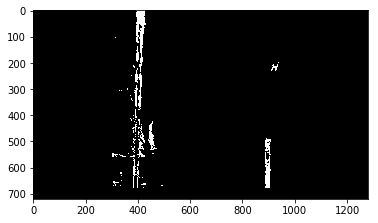

In [178]:
warped , M, Minv = bird_eyes(pipelined,src_corners, dst_corners)
warped[warped > 0 ] = 1
warped_cutted = remove_edge_pixels(warped)
plt.imshow(warped_cutted, cmap="gray")
plt.show()

## Line Finding Method: Peaks in a Histogram

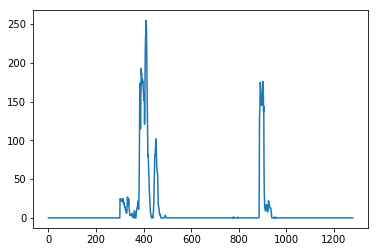

In [179]:
import numpy as np
histogram = np.sum(warped_cutted[warped_cutted.shape[0]//2-200:,:], axis=0)
plt.plot(histogram)
plt.show()

## Sliding windows 

In [180]:
def draw_polyfit( input_image, left_fitx, right_fitx):

    # Draw the lane onto the warped blank image
#     cv2.fillPoly(temp, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(temp, np.int_([right_line_pts]), (0,255, 0))
    result = np.copy(input_image)
#     result = cv2.addWeighted(input_image, 1, temp, 0.25, 0)
    yellow = [255,255,102]
  
    for y, x  in enumerate(left_fitx):
        if x > 0 and x <  input_image.shape[1]:
            result[y,int(x) ] = yellow
            if x < input_image.shape[1] - 5:
                result[y,int(x) +1 ] = yellow
                result[y,int(x) +2 ] = yellow
                result[y,int(x) +3 ] = yellow
            if x > 5:    
                result[y,int(x) -1 ] = yellow
                result[y,int(x) -2 ] = yellow

    for y, x  in enumerate(right_fitx):
        if x > 0 and x <  input_image.shape[1]:
            result[y,int(x) ] = yellow
            if x < input_image.shape[1] - 5:
                result[y,int(x) +1 ] = yellow
                result[y,int(x) +2 ] = yellow
                result[y,int(x) +3 ] = yellow
            if x > 5:    
                result[y,int(x) -1 ] = yellow
                result[y,int(x) -2 ] = yellow
                result[y,int(x) -3 ] = yellow

    return result

In [181]:
##### import numpy as np
import cv2
import matplotlib.pyplot as plt

def sliding_windows(input_image):
    # Assuming you have created a warped binary image called "binary_warped"
    #Take a histogram of the bottom half of the image
    histogram = np.sum(input_image[input_image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((np.zeros_like(input_image), input_image, input_image)) 
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
#     print ( "midpoint = " + str(midpoint ))
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#     print ( "leftx_base = " + str(leftx_base ))
#     print ( "rightx_base = " + str(rightx_base ))

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(input_image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = input_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 30
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
#         print ("window" )
        # Identify window boundaries in x and y (and right and left)
        win_y_low = input_image.shape[0] - (window+1)*window_height
        win_y_high = input_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        
#         print ( "win_xleft_low = " + str(win_xleft_low))
#         print ( "win_y_low = " + str(win_y_low))
#         print ( "win_xleft_high = " + str(win_xleft_high))
#         print ( "win_y_high = " + str(win_y_high))
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (255,255,255), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (255,255,255), 5) 
#         plt.imshow(out_img,cmap="gray")
#         plt.show()
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

#     out_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0 ]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    out_img = np.uint8(out_img)
    ploty = np.linspace(0, undst.shape[0]-1, undst.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    image_draw_polyfit = draw_polyfit(out_img, left_fitx, right_fitx)


    return  image_draw_polyfit , left_fit , right_fit



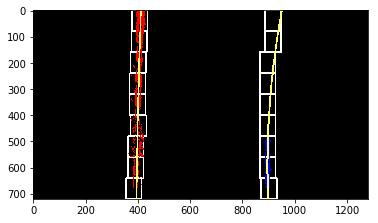

In [182]:
out_img , left_fit_sliding , right_fit_sliding = sliding_windows (warped_cutted)
    

# # Fit a second order polynomial to each

plt.imshow(out_img)
plt.show()




### Skip the sliding windows step once you know where the lines are

In [183]:
def find_lanes(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
    out_img = draw_polyfit(out_img, left_fitx, right_fitx)

    out_img = np.uint8(out_img)
    
    return  out_img , \
            left_fit , \
            right_fit

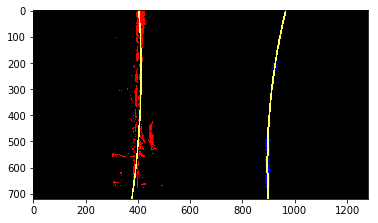

In [184]:
out_img, left_fit,right_fit = find_lanes(warped_cutted, left_fit_sliding, right_fit_sliding)


plt.imshow(out_img)
plt.show()

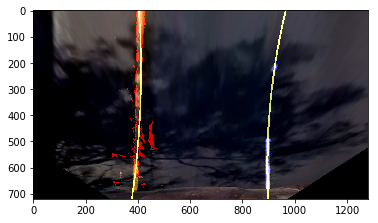

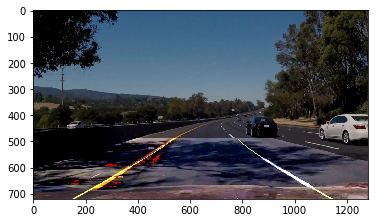

In [185]:
ori_warped , M, Minv = bird_eyes(undst,src_corners, dst_corners)

merged = cv2.addWeighted(ori_warped , 1, out_img  , 0.85, 0)

merged_back_wrapped = cv2.warpPerspective(merged, Minv, ( merged.shape[1], merged.shape[0]), flags=cv2.INTER_LINEAR)
merged_back_wrapped_and_ori = cv2.addWeighted(merged_back_wrapped , 1, undst  , .75, 0)

# plt.imshow(merge_draw_with_ori(draw_polyfit, warped))
plt.imshow(merged)
plt.show()    

plt.imshow(merged_back_wrapped_and_ori)
plt.show()




In [186]:
ori_warped[ori_warped>0]

array([ 5,  5, 15, ..., 35, 30, 30], dtype=uint8)

In [187]:
warped.shape

(720, 1280)

In [188]:
def draw_area_and_warpback(ori_undst_img ,left_fit, right_fit, Minv ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(ori_undst_img).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, ori_undst_img.shape[0]-1, ori_undst_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (ori_undst_img.shape[1], ori_undst_img.shape[0])) 
    # Combine the result with the original image
    result = newwarp
    result = cv2.addWeighted(ori_undst_img, 1, newwarp, 0.3, 0)

    
    return result


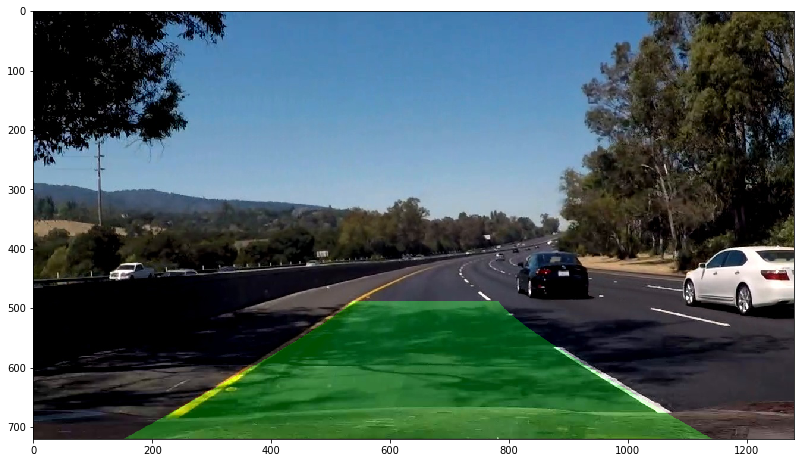

In [189]:
fig1 = plt.figure(figsize = (30,30)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
plt.imshow(draw_area_and_warpback(undst,left_fit, right_fit, Minv))
# plt.imshow(warped)
plt.show()



### Working on Video

In [190]:
def draw_processing_inlay(final, out_img, text, lay_number, left_or_right_pos) :
        # Add the processing window. Shows Histogram fitting errors
        font = cv2.FONT_HERSHEY_SIMPLEX
#         fit_errors = "L: {:0.4f}  R: {:0.4f}".format(np.sum(left_line.current_fit_error**2),np.sum(right_line.current_fit_error**2))
    
        if out_img is None:
            if left_or_right_pos == "left":
                x_offset =  20
            else:
                x_offset = final.shape[1]- 450

            y_offset = 55 + 40* (lay_number - 1)
            final = cv2.putText(final,text,(x_offset,y_offset), font, .8,(255,0,0),1,lineType = cv2.LINE_AA)
        else:
            if left_or_right_pos == "left":
                x_offset =  20
            else:
                x_offset = final.shape[1]- 230

            y_offset = 25 + 200* (lay_number - 1)
            out_img = cv2.resize(out_img,(int(320*.8),int(240*.8)))
            out_img = cv2.putText(out_img,text,(10,30), font, .7,(255,0,0),1,lineType = cv2.LINE_AA)
            final[y_offset:y_offset+out_img.shape[0], x_offset:x_offset+out_img.shape[1]] = out_img

            final[y_offset:y_offset+out_img.shape[0], x_offset:x_offset+out_img.shape[1]] = out_img
            
        return final

In [315]:
# Define a class to receive the characteristics of each line detection
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

class Line():
    def __init__(self, x_len, y_len):
        self.i  = 0

        #polynomial coefficients for the most last n fits
        self._coeff_history = []  
        
        #radius of previous curvature calculated of last 3 fits 
        self._current_fit =[]

        self.ym_per_pix = 30/720
        self.xm_per_pix = 3.7/700 
        self.x_len = x_len
        self.y_len = y_len

        
        self.ploty = np.linspace(0, y_len-1, y_len )
        self.y_eval = np.max(self.ploty)
        
        # the radius of the actual frame ( that can be eventually discared)
        self._actual_radius = None
        
        self.perc_diff_radius = None
        
        self.text = ""
        
        self.number_of_previous = 3
        
        self.perc_diff_fit_c = None
        
        self.discarded_fits = 0
        self.diff_curv_meters_with_previous = 0 

    def get_curv_meters (self, temp_fitx=None):
        
        if len(self._coeff_history) > 0 :
            # Fit new polynomials to x,y in world space
            fit_cr = np.polyfit(self.ploty*self.ym_per_pix, self.current_fitx*self.xm_per_pix, 2)
            # Calculate the new radii of curvature
            curverad = ((1 + (2*fit_cr[0]*self.y_eval*self.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

            ## result in meters
            return curverad
        else:
            return None
            
    
    
    @property
    def coeff_history(self):
        return self._coeff_history
    
    @coeff_history.setter
    def coeff_history(self,fit):
        self._coeff_history.append(fit)
        ### keeping only the last 3 fits
        self._coeff_history = self._coeff_history[-self.number_of_previous:]

    @property
    def coeff_history_avg_fit(self):
        ### calculating the average on last 3 fits
        
        if len(self._coeff_history) > 0:
            w_fity=np.array([])
            w_fitx=np.array([])
            for coeffs in self._coeff_history:
                w_fitx = np.append(w_fitx,
                       [coeffs[0]*self.ploty**2 +\
                        coeffs[1]*self.ploty    +\
                        coeffs[2]])
                w_fity = np.append(w_fity, self.ploty)
            return np.polyfit(w_fity, w_fitx, 2)
        else:
            return []
    
    
    ### calculating the difference between the average history fit and the actual
    def input_vs_history_fit(self, input_fit):
        if len(self._coeff_history ) > 0 :
            w_hist_fitx =  [self.coeff_history_avg_fit[0]*self.ploty**2 +\
                            self.coeff_history_avg_fit[1]*self.ploty    +\
                            self.coeff_history_avg_fit[2]]

            w_input_fitx =  [input_fit[0]*self.ploty**2 +\
                             input_fit[1]*self.ploty    +\
                             input_fit[2]]

#             return int(mean_squared_error(w_hist_fitx, w_input_fitx))
            return mean_squared_error(w_hist_fitx, w_input_fitx)

        else:
            return 0

    @property
    def current_fit(self):
        return self._current_fit
        
    @current_fit.setter    
    def current_fit (self, input_fit):
#         print (" ")
#         print (" ---- input fit " + str(input_fit))
        w_actual_fitx =  input_fit[0]*self.ploty**2 +\
                         input_fit[1]*self.ploty    +\
                         input_fit[2]
    
        # Fit new polynomials to x,y in world space
        fit_cr_tmp = np.polyfit(self.ploty*self.ym_per_pix, w_actual_fitx*self.xm_per_pix, 2)
        # Calculate the new radii of curvature
        w_actual_curv_meters = ((1 + (2*fit_cr_tmp[0]*self.y_eval*self.ym_per_pix + fit_cr_tmp[1])**2)**1.5) \
                / np.absolute(2*fit_cr_tmp[0])

    
        w_previous_curv_meters = self.get_curv_meters() 
        if w_previous_curv_meters :
            w_diff_curv_meters_with_before = abs(w_actual_curv_meters - w_previous_curv_meters ) \
                                            /w_previous_curv_meters * 100

            self.diff_curv_meters_with_previous = w_diff_curv_meters_with_before
#             print ( "diff_curv_meters_with_previous" + str(self.diff_curv_meters_with_previous))
        else:
            self.diff_curv_meters_with_previous = 0
#             print ( "diff_curv_meters_with_previous" + str(self.diff_curv_meters_with_previous))

        
        if (self.input_vs_history_fit(input_fit)) < 600 or self.discarded_fits > 45 \
                or self.diff_curv_meters_with_previous > 100 :

            self._current_fit = input_fit
            self.coeff_history = input_fit
            self.discarded_fits = 0 

        else:
            self.discarded_fits += 1

        #### need to calculate the Difference between the average Polyfit of last n frames
        #### and the actual polyfit

    @property     
    def current_fitx(self):
        return self.current_fit[0]*self.ploty**2 +\
                self.current_fit[1]*self.ploty    +\
                self.current_fit[2]
        
#         w_actual_radius = ((1 + (2*input_fit[0]*self.y_eval*self.ym_per_pix \
#                                  + input_fit[1])**2)**1.5) \
#                                  / np.absolute(2*input_fit[0])

        


In [316]:
from PIL import Image
import math

def process_image(input_img):
#     print ("*")
#     print ("******* START ")
#     print ("*")

    #######    
    ## undistort the image based on previous Camera Calibration
    #######
    undst = cv2.undistort(input_img, mtx, dist, None, mtx)

    #######    
    ## determine the image dimension 
    #######
    x_len = input_img.shape [1]
    y_len = input_img.shape [0]
    
    #######    
    ## IMAGE WARPING POINTS 
    #######    
    src_corners = calc_src_corners(input_img)
    dst_corners = calc_dst_corners(input_img)


    #######    
    ## FINDING LANE POINTS USING DIFFERENT TECHNIQUES 
    ## THE OUTPUT IMAGES ARE BINARY
    #######    
    combined_thresholds_binary , mag_binary , dir_binary, s_binary = pipeline(undst)
    #######    
    ## CHANGING THE PERSPECTIVE OF THE  combined_thresholds_binary 
    #######    


    wrapped_binary_tmp, M, Minv = bird_eyes( combined_thresholds_binary, src_corners, dst_corners)    
    #     wrapped_binary[wrapped_binary > 0 ] = 1

    #######    
    ## CUTTING THE NON INTERESTING AREAS ON THE LEFT AND RIGHT SIDE AND BOTTOM( FRONT OF THE CAR)
    #######    
    wrapped_binary = remove_edge_pixels(wrapped_binary_tmp)
    #######    
    ## Finding lanes 
    #######    
    if len ( left_line.coeff_history) ==0:
#         print (" using sliding windows ")
        # using sliding windows for the first read
        out_img_lanes , left_fit , right_fit = sliding_windows (wrapped_binary)

    else:
        # finding lanes using previous fit ( without sliding windows)
        out_img_lanes , left_fit,right_fit          = find_lanes(wrapped_binary, \
                                                                   left_line.coeff_history[-1], \
                                                                   right_line.coeff_history[-1])
    ######
    ## ADDING the LEFT AND RIGHT FIT to the left_line and right_lane    
    #   !!! eventually will be discared by Line Class setter !!! 
    #       --> in case discrepancy from previous average
    ######

    left_line.current_fit = left_fit
    right_line.current_fit = right_fit

    left_diff_text = "LEFT mean sq. error = "+str(left_line.input_vs_history_fit(left_fit))
    right_diff_text = "RIGHT mean sq. error = "+str(right_line.input_vs_history_fit(right_fit))

    #######    
    ## NOW I DRAW THE GREEN AREA BETWEEN LINES ON THE FINAL OUTPUT IMAGE
    ## the image will be also wrapped back using inverse perspective transform
    #######    
    final = draw_area_and_warpback(undst,left_line.current_fit, right_line.current_fit,Minv )

    
    #######    
    ## adding different boxes on the left of the final output image
    #######    

    undst_bird_eyes, M, Minv = bird_eyes( undst, src_corners, dst_corners)    

    ### 1st WINDOW
    final = draw_processing_inlay(final, np.dstack((combined_thresholds_binary,\
                                                    combined_thresholds_binary,\
                                                    combined_thresholds_binary))*255 \
                                  , "Pipeline", 1, "left")   


    ### 2st WINDOW
    final = draw_processing_inlay(final, np.dstack((wrapped_binary,\
                                                    wrapped_binary,\
                                                    wrapped_binary))*255 \
                                  , "wrapped binary", 2, "left")   

    ### 3st WINDOW

    ori_warped , M, Minv = bird_eyes(undst,src_corners, dst_corners)
    merged = cv2.addWeighted(ori_warped , 1, out_img_lanes  , 0.85, 0)

#     merged_back_wrapped = cv2.warpPerspective(merged, Minv, \
#                                               ( merged.shape[1], merged.shape[0]), \
#                                               flags=cv2.INTER_LINEAR)
    
#     merged_back_wrapped_and_ori = cv2.addWeighted(merged_back_wrapped , 1, undst  , 0.35, 0)

    final = draw_processing_inlay(final, \
                                  merged\
                                  , "Poly", 3, "left")   



#     final = draw_processing_inlay(final, merged_back_wrapped_and_ori , "Polyfit", 3, "left")   

    ####
    ### calculate the offset
    ####

    camera_position = left_line.x_len/2
    lane_center = (right_line.current_fitx[719] + left_line.current_fitx[719])/2
    center_offset_pixels = camera_position - lane_center
    center_offset_meters = left_line.xm_per_pix * center_offset_pixels


        
    #######    
    ### Printing text on the right side of the output image
    #######    
    final = draw_processing_inlay(final,None, "LEFT  CURVE = %4.1f (m)"% \
                                  left_line.get_curv_meters()\
                                  , 1, "right")   
    
    final = draw_processing_inlay(final,None, "diff perc.  = %4.1f (m)"% \
                                  left_line.diff_curv_meters_with_previous\
                                  , 2, "right")   

    final = draw_processing_inlay(final,None, "RIGHT CURVE = %4.1f (m)"% \
                                  right_line.get_curv_meters()\
                                  , 3, "right")   
    
    final = draw_processing_inlay(final,None, "diff perc.  = %4.1f (m)"% \
                                  right_line.diff_curv_meters_with_previous\
                                  , 4, "right")   


    if center_offset_meters < 0 :
        text  = "CAR SLIGHTLY ON LEFT SIDE"
    else:
        text  = "CAR SLIGHTLY ON RIGHT SIDE"
    text2 = "FROM THE CENTER %3.2f (m)"% center_offset_meters

    final = draw_processing_inlay(final,None, text ,5, "right")   
    final = draw_processing_inlay(final,None, text2,6, "right")   


    final = draw_processing_inlay(final,None, left_diff_text, 8, "right")   
    final = draw_processing_inlay(final,None, "LEFT DISCARDED " + str(left_line.discarded_fits), 9, "right")   

    final = draw_processing_inlay(final,None, right_diff_text, 10, "right")   
    final = draw_processing_inlay(final,None, "RIGHT DISCARDED " + str(right_line.discarded_fits), 11, "right")   

    left_line.i += 1
    
    cv2.imwrite("temp.nosync/final" +str(left_line.i) + ".jpg", cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
    return final

In [317]:
x_len = undst.shape [1]
y_len = undst.shape [0]


left_line  = Line(x_len, y_len)
right_line = Line(x_len, y_len)

for i in range(970,990):
    test_image = cv2.imread("test_images3/image" + str(i) + ".jpg")
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#     camera_position = test_image.shape[1]/2
    
#     print("camera position " + str(camera_position))

    aa = process_image(test_image)
    fig1 = plt.figure(figsize = (80,80)) # create a figure with the default size 
    ax1 = fig1.add_subplot(2,2,1) 
    ax1.imshow(aa, interpolation='none')
    plt.axis('off')
    
    plt.show()

KeyboardInterrupt: 

In [ ]:
x_len = undst.shape [1]
y_len = undst.shape [0]
left_line  = Line(x_len, y_len)
right_line = Line(x_len, y_len)

from moviepy.editor import VideoFileClip
output_video_name = 'project_video_output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.subclip(38,43)
output_video = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time output_video.write_videofile(output_video_name, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


 73%|███████▎  | 925/1261 [07:15<03:05,  1.81it/s]